In [8]:
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

from torch import nn, optim

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [9]:
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
# Load the MNIST dataset
mnist_dataset_train = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
# Load the test MNIST dataset
mnist_dataset_test = datasets.MNIST(root='./data', train=False, download=False, transform=transform) # download=True

batch_size = 128
train_loader = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=5, shuffle=False)

In [10]:
class DAE(nn.Module):
	def __init__(self):
		super().__init__()

		self.fc1 = nn.Linear(784, 512)
		self.fc2 = nn.Linear(512, 256)
		self.fc3 = nn.Linear(256, 128)

		self.fc4 = nn.Linear(128, 256)
		self.fc5 = nn.Linear(256, 512)
		self.fc6 = nn.Linear(512, 784)

		self.relu = nn.ReLU()
		self.sigmoid = nn.Sigmoid()

	def encode(self, x):

		h1 = self.relu(self.fc1(x))
		h2 = self.relu(self.fc2(h1))
		return self.relu(self.fc3(h2))

	def decode(self, z):
		h4 = self.relu(self.fc4(z))
		h5 = self.relu(self.fc5(h4))
		return self.sigmoid(self.fc6(h5))

	def forward(self, x):
		q = self.encode(x.view(-1, 784))

		return self.decode(q)

In [36]:
def train(epoch, model, train_loader, optimizer, cuda=True):
    model.train()
    train_loss = 0
    average_train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data.to(device)
        optimizer.zero_grad()

        data_noise = torch.randn(data.shape).to(device)
        data_noise = data + data_noise

        recon_batch = model(data_noise.to(device))
        loss = criterion(recon_batch, data.view(data.size(0), -1).to(device))
        loss.backward()

        train_loss += loss.item() * len(data)
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
																		100. * batch_idx /
																		len(train_loader),
																		loss.item()))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    average_train_loss += train_loss / len(train_loader.dataset)
    return average_train_loss

In [37]:
epochs = 10

model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [38]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'total params = {pytorch_total_params}')

total params = 1132944


In [43]:
average_train_loss = []
for epoch in range(1, epochs + 1):
	average_train_loss.append(train(epoch, model, train_loader, optimizer, True))

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.034136
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.034850
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.038040
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.037701
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.035130
====> Epoch: 1 Average loss: 0.0365
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034195
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.039209
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.034457
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.036075
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.037144
====> Epoch: 2 Average loss: 0.0363
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.038761
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.036892
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.034940
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.035689
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.037031
====> Epoch: 3 Average loss: 0.0363
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.035435
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.035434
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.036249
Train Epoch:

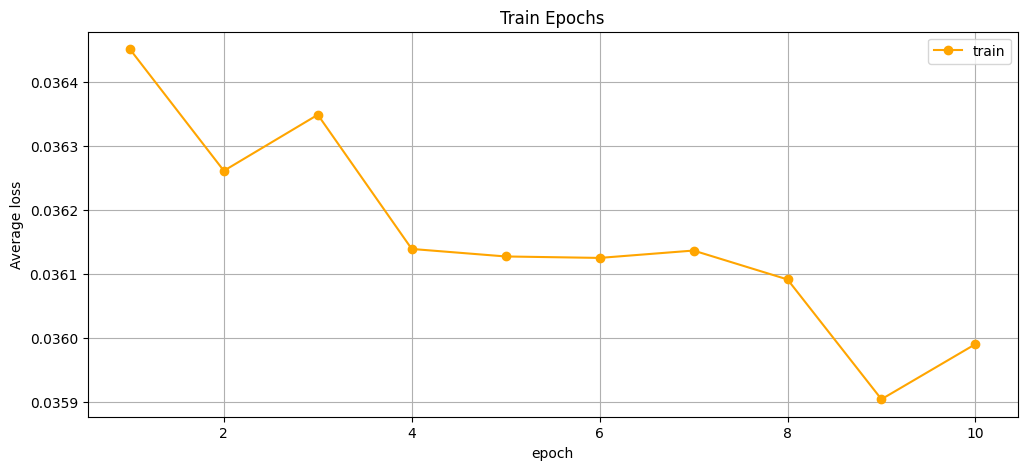

In [46]:
def plot_loss(Loss):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, epochs + 1), Loss, color='orange', label='train', marker='o')
    # plt.plot(range(len(Loss_val)), Loss_val, color='blue', linestyle='--', label='val')
    plt.xlabel('epoch') 
    plt.ylabel('Average loss') 
    plt.title('Train Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(average_train_loss)

 Image 0 with label 7  Image 1 with label 2  Image 2 with label 1  Image 3 with label 0  Image 4 with label 4 

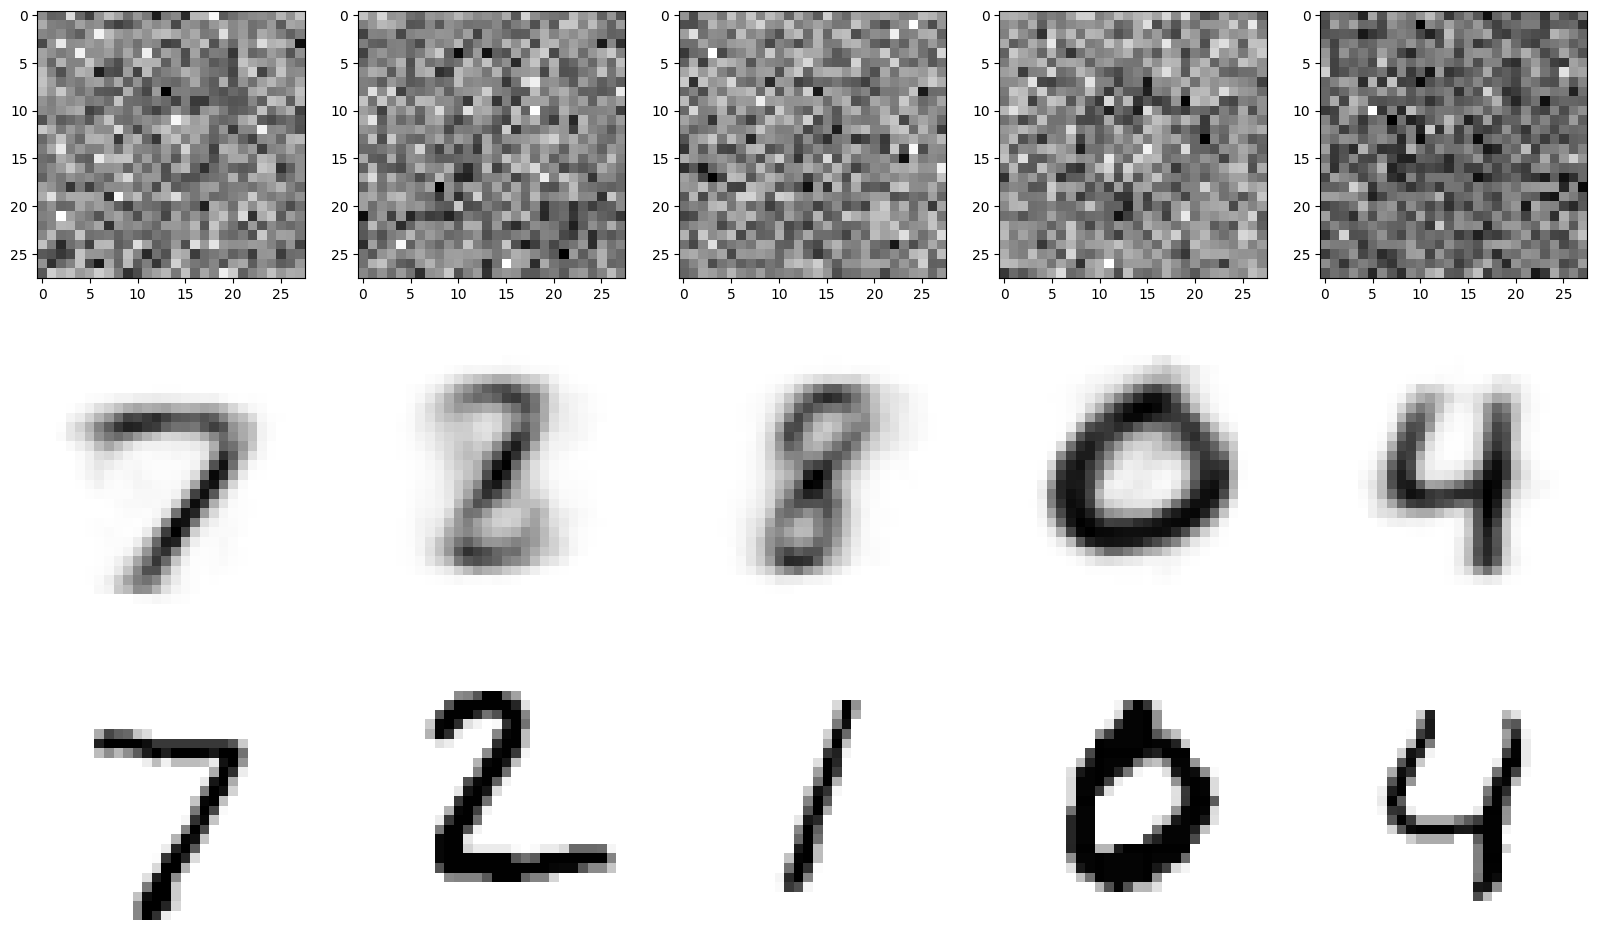

In [47]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
	data.to(device)
	optimizer.zero_grad()

	data_noise = torch.randn(data.shape).to(device)
	data_noise = data + data_noise

	recon_batch = model(data_noise.to(device))
	break


plt.figure(figsize=(20, 12))
for i in range(5):

	print(f" Image {i} with label {labels[i]} ", end="")
	plt.subplot(3, 5, 1+i)
	plt.imshow(data_noise[i, :, :, :].view(28, 28).detach().numpy(), cmap='binary')
	plt.subplot(3, 5, 6+i)
	plt.imshow(recon_batch[i, :].view(28, 28).detach().numpy(), cmap='binary')
	plt.axis('off')
	plt.subplot(3, 5, 11+i)
	plt.imshow(data[i, :, :, :].view(28, 28).detach().numpy(), cmap='binary')
	plt.axis('off')
plt.show()